In [97]:
import matplotlib.pyplot as plt
from IPython.core.display import display
from PIL import Image
from matplotlib.ticker import NullLocator
import numpy as np
import glob
import pandas as pd
import json
import os
from sklearn import preprocessing

def combine_heatmaps(game_name, normalized=False):
    agent_types = ["dqn_training", "human", "random", "self_class"]
    images = []

    for i in range( len(agent_types) ):
        if normalized:
            path = "../data/heatmaps/normalized_avg_" + game_name + "/" + agent_types[i] + "/" + "*.jpg"
        else:
            path = "../data/heatmaps/avg_" + game_name + "/" + agent_types[i] + "/" + "*.jpg"
        if len(glob.glob(path)) == 0: # if one of the image files do not exist
            print( "Cannot concatanate: File " + path + " does not exist." )
            return
        images.append(Image.open(glob.glob(path)[0]))

    h1 = get_concat_h(images[0], images[1])
    h2 = get_concat_h(images[2], images[3])

    combined = get_concat_v(h1, h2)
    display(combined)

    if normalized:
        combined.save(game_name + "_norm_concat.jpg")
    else:
        combined.save(game_name + "_concat.jpg")


# concatanate vertically
def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

# concatanate horizontally
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def plot_heatmap(normalise, state_counts, file, game_type, agent_type, avg=False):
    if normalise:
        state_counts = preprocessing.normalize(state_counts)

    plt.imshow(state_counts.T, cmap='viridis')
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
        hspace = 0, wspace = 0)
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    base = os.path.basename(file)

    game_titles = {
        "shuffleKeys_game": "Shuffle Keys",
        "contingency_game": "Contingency",
        "logic_game": "Logic"
    }
    
    agent_titles = {
        "dqn_training": "DQN Training",
        "human": "Human",
        "random": "Random",
        "self_class": "Self Class"   
    }

    if normalise and avg:
        path = "../data/heatmaps/normalized_avg_" + game_type + "/" + agent_type + "/"
        title = game_titles[game_type] + " (Norm. Avg): " + agent_titles[agent_type]
    elif normalise:
        path = "../data/heatmaps/normalized_" + game_type + "/" + agent_type + "/"
        title = game_titles[game_type] + " (Normalized): " + agent_titles[agent_type]
    elif avg:
        path = "../data/heatmaps/avg_" + game_type + "/" + agent_type + "/"
        title = game_titles[game_type] + " (Avg): " + agent_titles[agent_type]
    else:
        path = "../data/heatmaps/" + game_type + "/" + agent_type + "/"
        title = game_titles[game_type] + ": " + agent_titles[agent_type]

    if not os.path.exists(path):
        os.makedirs(path)

    filename = path + os.path.splitext(base)[0] + '_heatmap.jpg'

    plt.title( title, fontweight='bold', fontsize=12 )

    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.show()


def make_heatmap(game_type, agent_type, normalise=False):
    df_r = pd.DataFrame()
    files = glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")
    if len(files) == 0:
        return False

    state_counts_sum = [] # to print the average plot of all episodes
    for file in files:
        data = json.load(open(file))
        self_locs = data.get("data")["self_locs"]
        map = data.get("data")["map"]

        level_amt = len( data.get("data")["level"] )
        width = len(map[0][0])
        height = len(map[0])

        state_counts = np.zeros((width, height))

        # read encountered states
        for level in range(level_amt):
            if len( self_locs[level] ) == 0:
                continue
            action_amt = len(self_locs[level][0])
            for i in range( action_amt ):
                x = self_locs[level][0][i]
                y = self_locs[level][1][i]
                state_counts[x, y] += 1

        # rotate the matrix
        state_counts = np.rot90(state_counts)

        state_counts_sum.append( state_counts )
        plot_heatmap(normalise, state_counts, file, game_type, agent_type)

    # Plot the average of all episodes:
    state_counts = np.zeros((width, height))
    for i in range( len(state_counts_sum) ):
        state_counts = np.add(state_counts, state_counts_sum[i])

    plot_heatmap(normalise, state_counts, file, game_type, agent_type, avg=True)
    return True

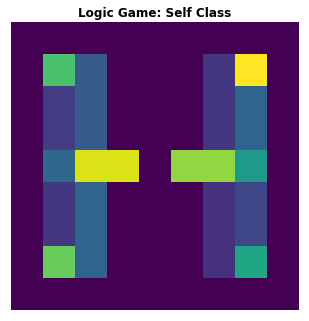

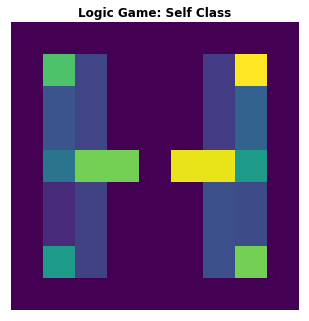

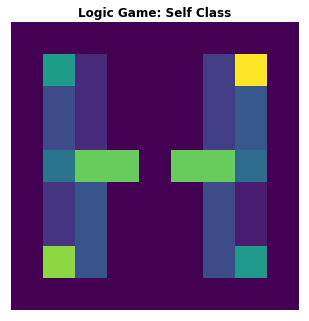

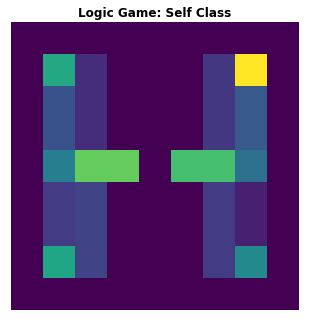

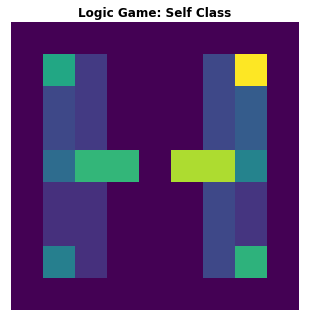

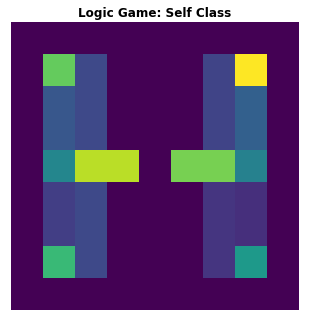

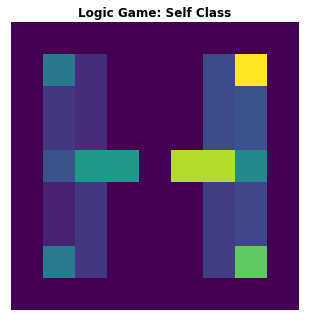

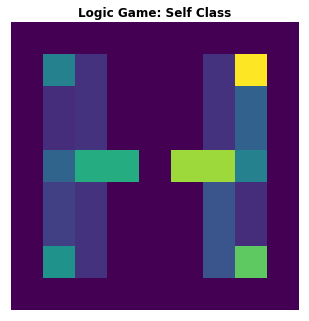

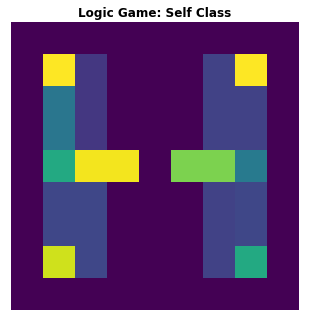

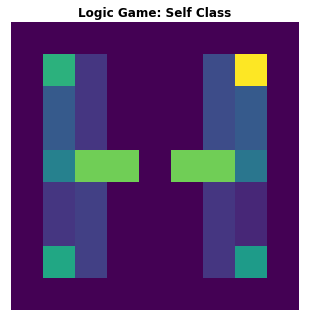

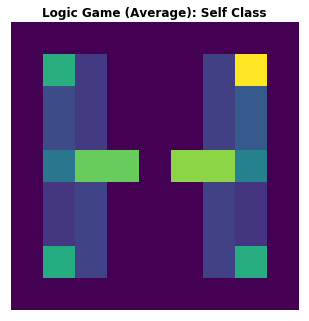

Heatmap file of logic_game: humanDNE.


In [80]:
# make heapmap for logic_game with self_class
make_heatmap("logic_game", "self_class")
combine_heatmaps("logic_game")
combine_heatmaps("logic_game", True) # combine normalized heatmaps

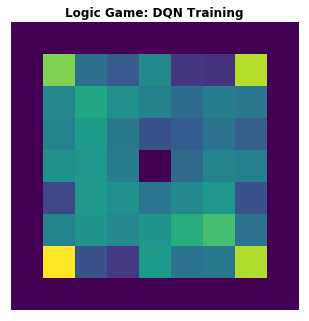

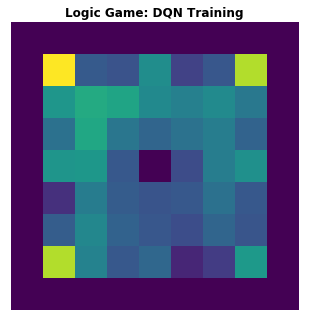

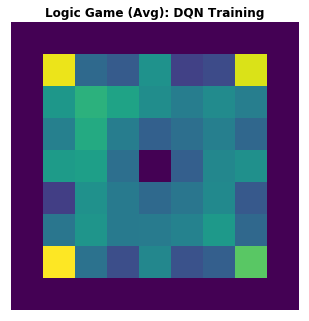

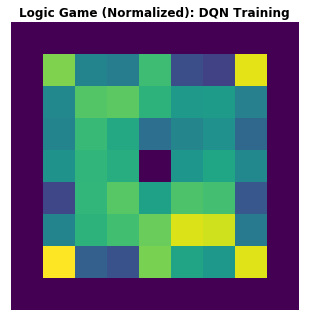

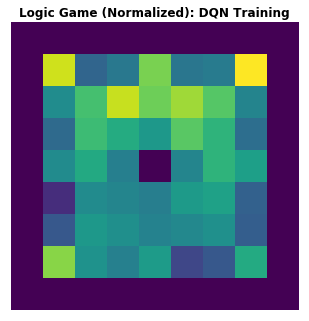

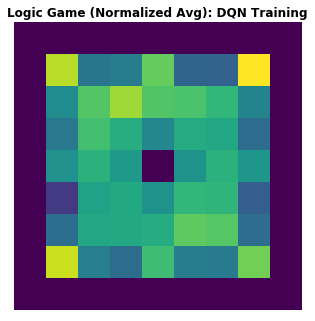

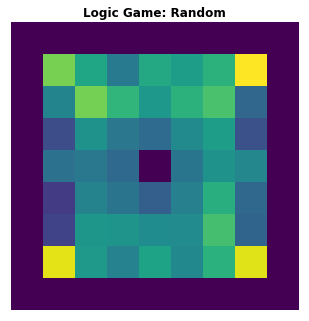

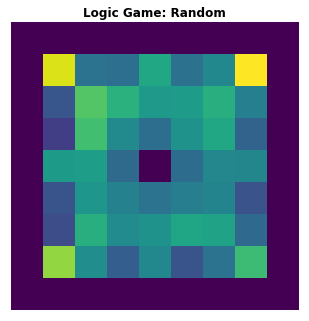

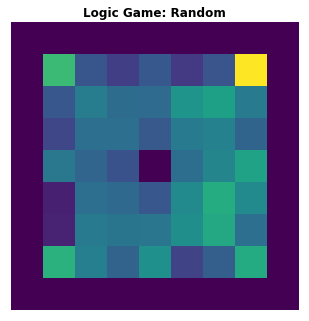

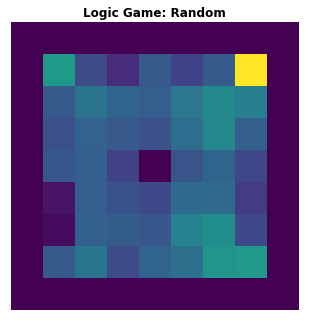

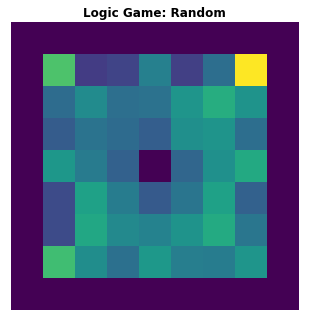

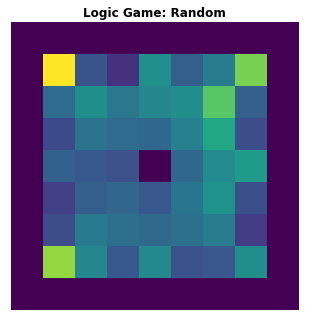

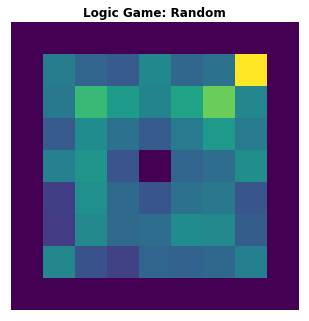

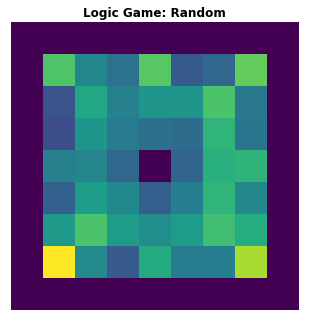

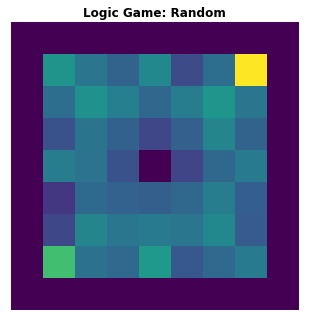

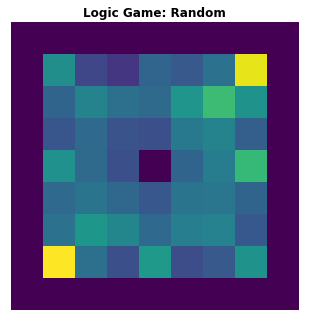

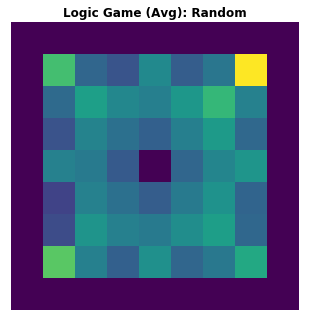

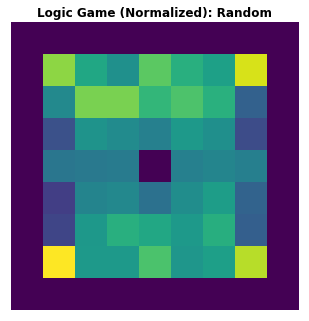

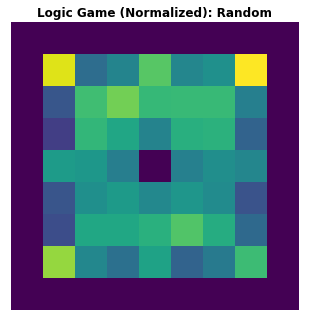

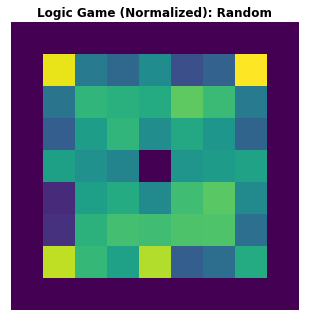

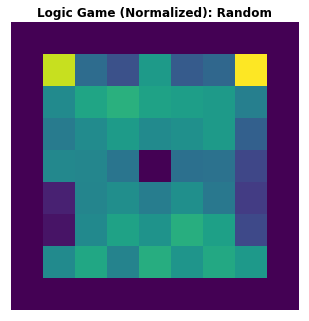

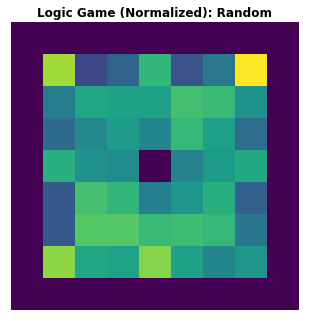

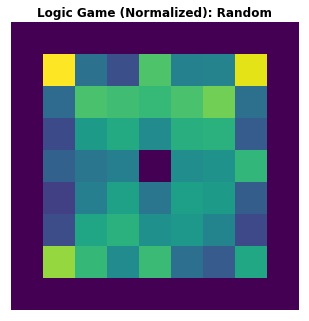

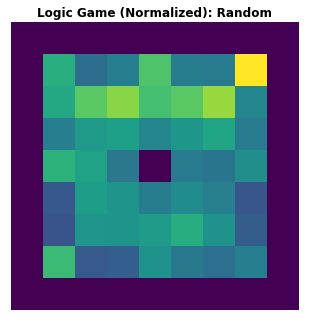

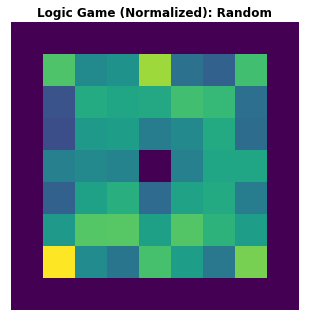

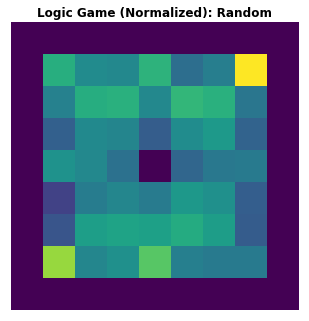

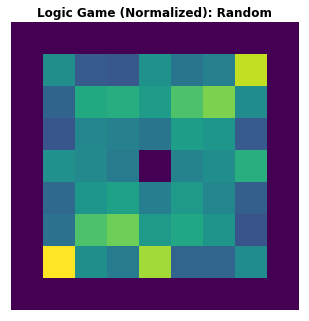

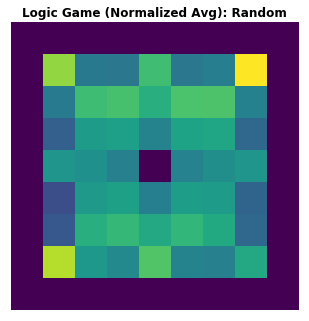

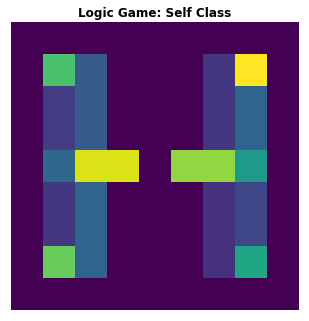

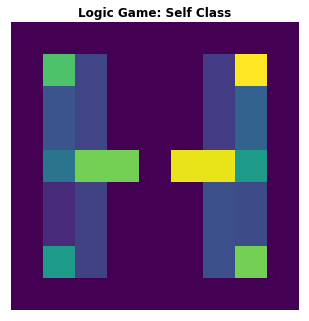

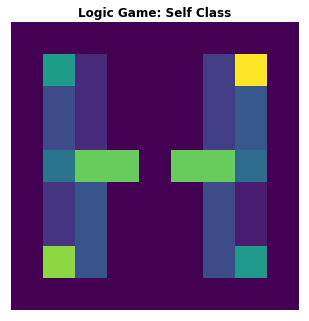

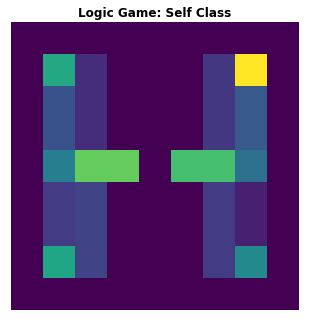

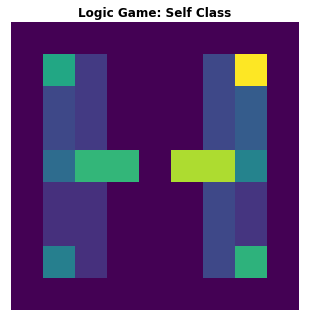

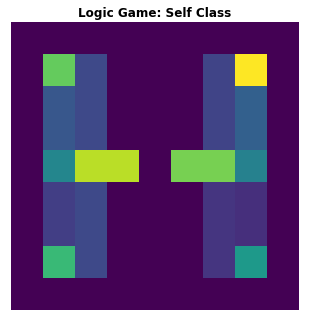

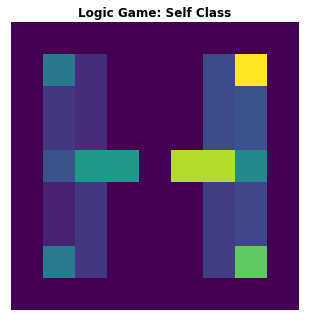

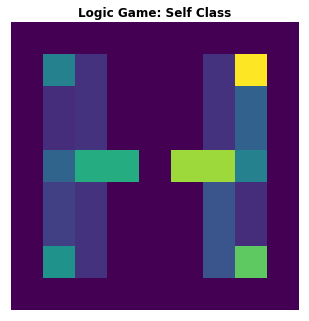

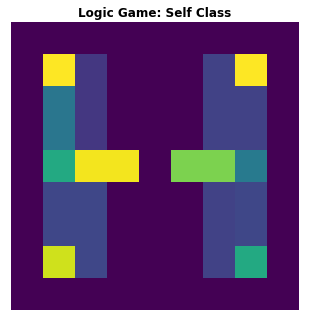

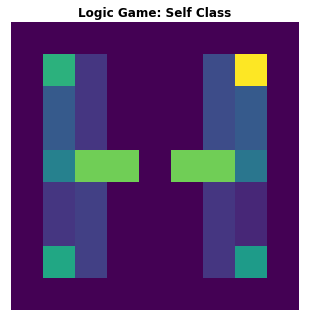

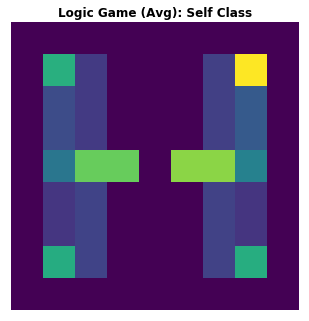

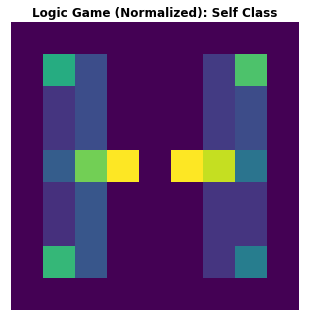

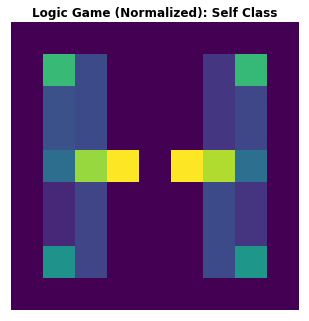

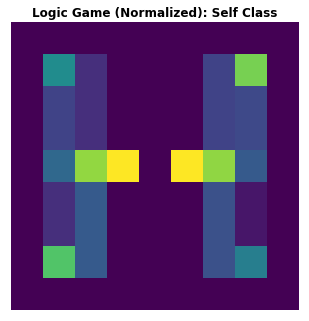

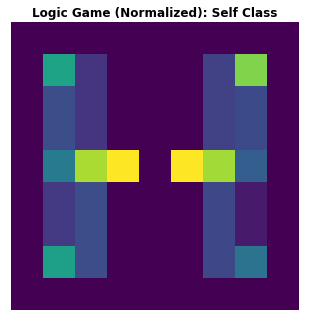

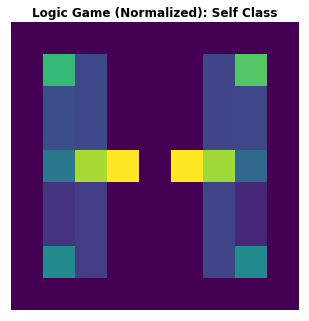

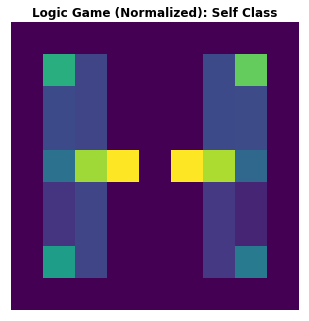

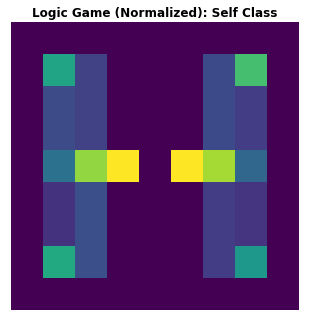

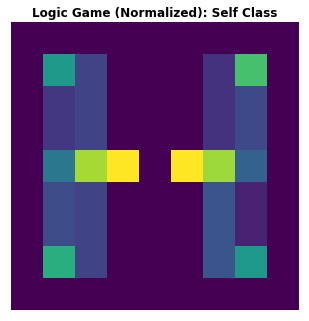

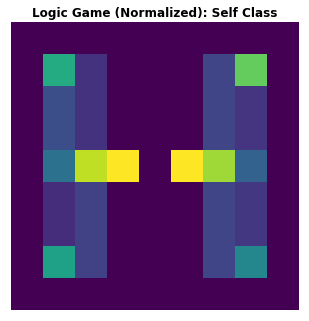

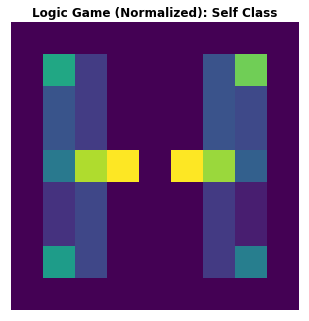

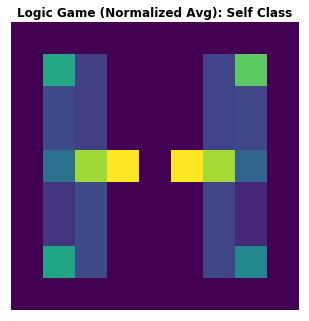

Cannot concatanate: File../data/heatmaps/avg_logic_game/human/*.jpg does not exist.
Cannot concatanate: File../data/heatmaps/normalized_avg_logic_game/human/*.jpg does not exist.


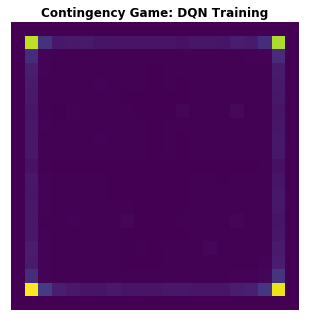

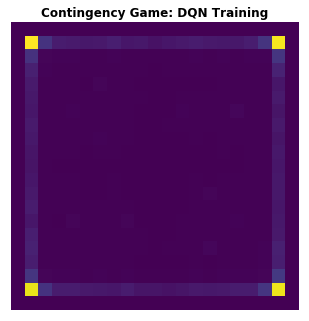

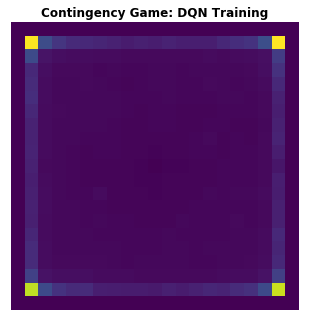

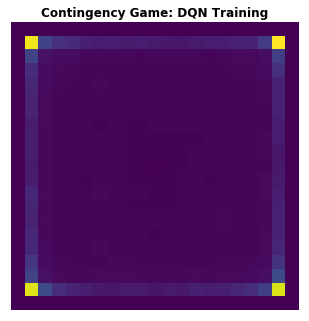

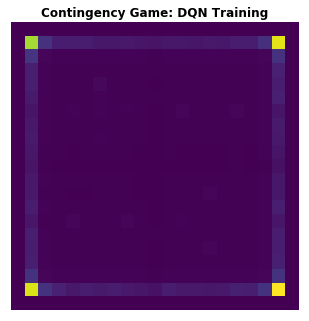

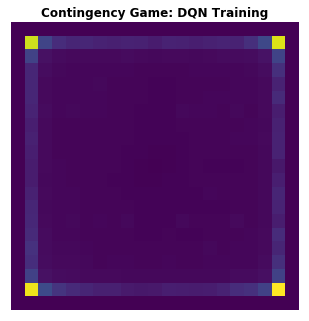

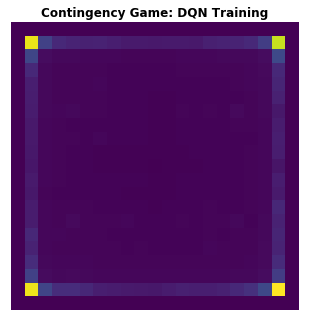

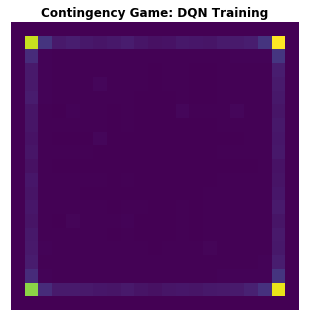

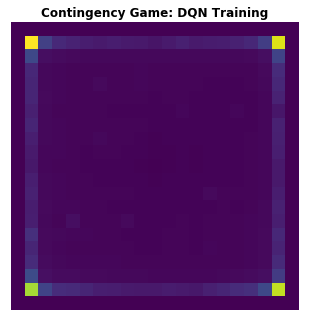

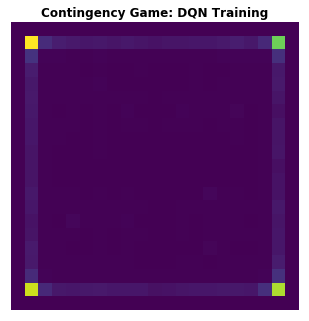

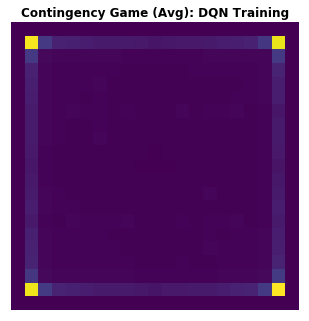

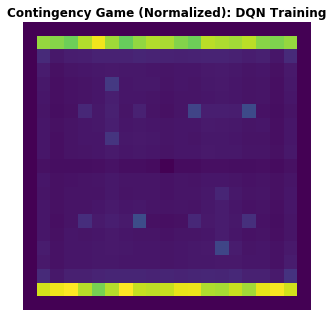

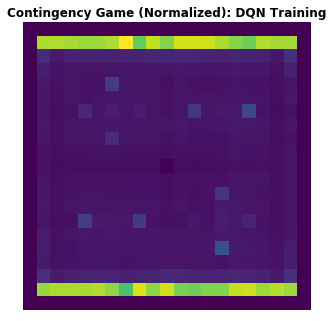

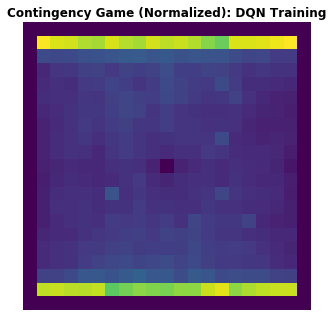

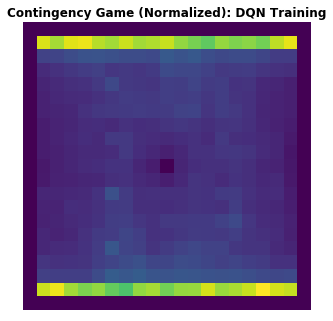

In [ ]:
# make heatmap for all game types and agent types
game_types = ("logic_game", "contingency_game") #shuffle_keys
agent_types = ("dqn_training", "human", "random", "self_class")

for game in game_types:
    for agent in agent_types:
        make_heatmap(game, agent)
        make_heatmap(game, agent, True) # make normalized heatmaps

    combine_heatmaps(game)
    combine_heatmaps(game, True) # combine normalized heatmaps
